### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


#### Install py4j
In addition install py4j v0.10.9.1-mm from my github clone
`git clone https://github.com/sedgewickmm18/py4j`

Install with
```
cd py4j-java
./gradlew clean assemble # build java jars
cd ..
pip install .  # install python and jars
```

#### Install timeseries-insights
Checkout WatFore forecasting library first

`git clone https://github.ibm.com/Common-TimeSeries-Analytics-Library/WatFore`

then timeseries-insights

`git clone https://github.ibm.com/Common-TimeSeries-Analytics-Library/timeseries-insights`

Finally apply a patch for allow for a callback server IP other than 127.0.0.1

`curl https://raw.githubusercontent.com/sedgewickmm18/tsi/master/context.py.patch | patch -p1`


Build WatFore
```
cd WatFore
mvn clean install -DskipTests
```

Build timeseries-insights
```
cd ../timeseries-insights
mvn clean install -DskipTests
```

Build the python distribution of tspy
```
cd python
python setup.py sdist
```

Install it

`pip install dist/tspy-2.0.5.0.tar.gz`


#### Run timeseries-insights as docker container

`docker run -p 25332:25332 -p 25333:25333 sedgewickmm18/tsi`

* port 25333 exposes the default port for the java server
* port 25332 allows for optional ssh based port forwarding (should not be necessary)

The patch above allows for callback server IP addresses other than 127.0.0.1, i.e. the python client that also acts as callback server for python lambda processing can listen to a docker bridge IP address. In my case I'm running it from my laptop on `172.17.0.1` while the container with the java process has IP address `172.17.0.2`.

##### Caveat:

The java process attempts to listen to IPv4 **and** IPv6 addresses so have to enable IPv6 for your docker bridge with

`sudo vi /etc/docker/daemon.json`

so that it looks similar to

```
{
    "insecure-registries" : ["localhost:32000"],
    "ipv6": true,
    "fixed-cidr-v6": "2001:db8:1::/64"
}
```

Then restart the docker daemon with

`systemctl restart docker`

and check with

`docker network inspect bridge`

In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)                 
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [3]:
# setting to make life easier
Temperature='Vx'



In [4]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2020-10-14T09:58:29.769 INFO iotfunctions.dbtables.__init__ Init FileModelStore


In [5]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('AllOfArmstark.csv', index_col=False, parse_dates=['timestamp'])

#df_i['entity']='MyRoom'
#df_i[Temperature]=df_i['value'] + 20
#df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

,,Vx,Vy,Vz,Ap,As,speed
entity,timestamp,,,,,,
04714B604101,2020-01-01 00:02:12.713,-0.0625,-0.0908,-1.0332,2.3650,1.036,1.042
04714B6046D5,2020-01-01 00:02:25.928,-0.0439,-0.0137,-1.0029,2.2904,1.036,1.036


In [6]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['04714B6046D5']]
df_inputm2.reset_index(level=[0], inplace=True)

# predicted just means normalized - need to modify the BaseEstimatorFunction superclass


In [7]:
# start the callback server

#from tspy import TSContext
import tspy
from tspy.data_structures.context import TSContext 
from py4j.java_gateway import JavaGateway, GatewayParameters, CallbackServerParameters


gateway = JavaGateway(gateway_parameters=GatewayParameters(address=u'172.17.0.2',
                                  auth_token='DZQv45+bq4TTHSF3FH2RoYqLoGjY2zMcojcQQpRFZMA='),
            callback_server_parameters=CallbackServerParameters(daemonize=True,port=25334,address=u'172.17.0.1',
                         auth_token='DZQv45+bq4TTHSF3FH2RoYqLoGjY2zMcojcQQpRFZMA=',daemonize_connections=True))



2020-10-14T09:58:45.810 INFO py4j.java_gateway.run Callback Server Starting
2020-10-14T09:58:45.812 INFO py4j.java_gateway.run Socket listening on ('172.17.0.1', 25334)


In [8]:
df_i

Vx      Vy      Vz      Ap     As  \
entity       timestamp                                                        
04714B604101 2020-01-01 00:02:12.713 -0.0625 -0.0908 -1.0332  2.3650  1.036   
04714B6046D5 2020-01-01 00:02:25.928 -0.0439 -0.0137 -1.0029  2.2904  1.036   
04714B604101 2020-01-01 00:03:12.713  0.0361  0.0078 -0.9141  2.3650  1.036   
04714B6046D5 2020-01-01 00:03:25.928 -0.0430 -0.0205 -0.9023  2.2904  1.036   
04714B604101 2020-01-01 00:04:12.713  0.1172 -0.0332 -0.9756  2.3650  1.036   
...                                      ...     ...     ...     ...    ...   
             2020-01-31 12:10:16.047 -0.0088 -0.0361 -0.9160  2.2800  1.032   
04714B6046D5 2020-01-31 12:10:23.501 -0.0879 -0.0322 -0.8750  2.2760  1.037   
             2020-01-31 12:11:23.501  0.0596 -0.0166 -0.9795  2.2744  1.037   
             2020-01-31 12:12:23.501  0.0801 -0.0215 -1.0166  2.2744  1.037   
             2020-01-31 12:13:23.501 -0.0957  0.0029 -0.9854  2.2744  1.037   

                                      speed  
entity       timestamp                       
04714B604101 2020-01-01 00:02:12.713  1.042  
04714B6046D5 2020-01-01 00:02:25.928  1.036  
04714B604101 2020-01-01 00:03:12.713  1.042  
04714B6046D5 2020-01-01 00:03:25.928  1.036  
04714B604101 2020-01-01 00:04:12.713  1.042  
...                                     ...  
             2020-01-31 12:10:16.047  1.033  
04714B6046D5 2020-01-31 12:10:23.501  1.037  
             2020-01-31 12:11:23.501  1.037  
             2020-01-31 12:12:23.501  1.037  
             2020-01-31 12:13:23.501  1.037  

[258495 rows x 6 columns]

In [9]:
import datetime

df = df_i.reset_index()[['entity','timestamp','Vx']] #['entity'=='04714B6046D5']
df = df[df['entity']=='04714B6046D5']


tsc = TSContext(gateway=gateway, jvm=gateway.jvm, daemonize=True)

model = tspy.forecasters.arima(500)

model_map = {
        '04714B6046D5': model,
}

In [10]:
df

,entity,timestamp,Vx
1,04714B6046D5,2020-01-01 00:02:25.928,-0.0439
3,04714B6046D5,2020-01-01 00:03:25.928,-0.0430
5,04714B6046D5,2020-01-01 00:04:25.928,0.0039
7,04714B6046D5,2020-01-01 00:05:25.928,0.0283
9,04714B6046D5,2020-01-01 00:06:25.928,-0.0771
...,...,...,...
258489,04714B6046D5,2020-01-31 12:09:23.501,0.0293
258491,04714B6046D5,2020-01-31 12:10:23.501,-0.0879
258492,04714B6046D5,2020-01-31 12:11:23.501,0.0596
258493,04714B6046D5,2020-01-31 12:12:23.501,0.0801


In [11]:
dfs = df.tail(20000)
mts_raw = tsc.multi_time_series\
        .df_observations(dfs, dfs.keys()[0], dfs.keys()[1], dfs.keys()[2], granularity=datetime.timedelta(milliseconds=1))\
        .with_trs(granularity=datetime.timedelta(minutes=1)) \
        .transform(tsc.duplicate_transforms.combine_duplicate_time_ticks(lambda x: float(sum(x) / len(x))))

In [12]:
dfss = mts_raw.to_df()

2020-10-14T09:58:58.828 INFO py4j.java_gateway.run Callback Connection ready to receive messages
2020-10-14T09:58:58.830 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.834 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.835 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.836 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.837 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.838 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.839 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.841 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.842 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.843 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.844 INFO py4j.java_gate

2020-10-14T09:58:58.927 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.928 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.929 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.930 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.930 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.931 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.932 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.935 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.936 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.937 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.938 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:58.939 INFO py4j.java_gateway.run Rec

2020-10-14T09:58:59.016 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.017 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.018 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.019 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.019 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.020 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.021 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.022 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.023 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.024 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.025 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.026 INFO py4j.java_gateway.run Rec

2020-10-14T09:58:59.111 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.112 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.112 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.113 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.114 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.114 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.115 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.118 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.119 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.120 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.120 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.121 INFO py4j.java_gateway.run Rec

2020-10-14T09:58:59.194 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.195 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.196 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.197 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.197 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.198 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.199 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.199 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.200 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.201 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.201 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.202 INFO py4j.java_gateway.run Rec

2020-10-14T09:58:59.280 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.280 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.281 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.282 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.282 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.283 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.284 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.285 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.285 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.286 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.287 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.288 INFO py4j.java_gateway.run Rec

2020-10-14T09:58:59.360 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.361 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.362 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.362 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.363 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.364 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.365 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.365 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.366 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.367 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.367 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.368 INFO py4j.java_gateway.run Rec

2020-10-14T09:58:59.422 INFO py4j.java_gateway.run Received command g on object id p1117
2020-10-14T09:58:59.422 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.423 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p1117
2020-10-14T09:58:59.423 INFO py4j.java_gateway.run Received command g on object id p1118
2020-10-14T09:58:59.424 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p1118
2020-10-14T09:58:59.424 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.425 INFO py4j.java_gateway.run Received command g on object id p1119
2020-10-14T09:58:59.425 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p1119
2020-10-14T09:58:59.426 INFO py4j.java_gateway.run Received command g on object id p1120
2020-10-14T09:58:59.426 WARNING py4j.java_gateway._garbage_collect_proxy Tried to 

2020-10-14T09:58:59.462 INFO py4j.java_gateway.run Received command g on object id p1147
2020-10-14T09:58:59.462 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p1147
2020-10-14T09:58:59.463 INFO py4j.java_gateway.run Received command g on object id p1148
2020-10-14T09:58:59.463 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p1148
2020-10-14T09:58:59.463 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.464 INFO py4j.java_gateway.run Received command g on object id p1149
2020-10-14T09:58:59.464 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p1149
2020-10-14T09:58:59.465 INFO py4j.java_gateway.run Received command g on object id p1150
2020-10-14T09:58:59.465 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p1150
2020-10-14T09:58:59.466 INFO py4j.java

2020-10-14T09:58:59.505 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p1178
2020-10-14T09:58:59.506 INFO py4j.java_gateway.run Received command g on object id p1179
2020-10-14T09:58:59.506 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.506 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p1179
2020-10-14T09:58:59.507 INFO py4j.java_gateway.run Received command g on object id p1180
2020-10-14T09:58:59.508 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p1180
2020-10-14T09:58:59.509 INFO py4j.java_gateway.run Received command g on object id p1181
2020-10-14T09:58:59.509 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.509 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p1181
2020-10-14T09:58:59.510 INFO py4j.java_ga

2020-10-14T09:58:59.560 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.560 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.561 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.562 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.563 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.563 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.564 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.565 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.566 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.567 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.567 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.568 INFO py4j.java_gateway.run Rec

2020-10-14T09:58:59.647 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.648 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.649 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.650 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.650 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.651 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.652 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.652 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.653 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.653 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.654 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.655 INFO py4j.java_gateway.run Rec

2020-10-14T09:58:59.719 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.720 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.720 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.721 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.722 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.722 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.723 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.724 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.727 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.728 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.729 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.730 INFO py4j.java_gateway.run Rec

2020-10-14T09:58:59.799 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.800 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.800 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.802 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.802 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.803 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.804 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.804 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.805 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.806 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.807 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.808 INFO py4j.java_gateway.run Rec

2020-10-14T09:58:59.873 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.874 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.875 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.875 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.879 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.880 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.881 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.882 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.882 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.883 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.884 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.885 INFO py4j.java_gateway.run Rec

2020-10-14T09:58:59.970 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.971 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.972 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.973 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.974 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.975 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.976 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.976 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.978 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.979 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.980 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:58:59.981 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:00.050 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.050 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.051 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.052 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.052 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.054 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.056 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.057 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.057 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.058 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.058 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.059 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:00.142 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.142 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.144 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.144 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.145 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.146 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.147 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.148 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.149 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.150 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.151 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.152 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:00.225 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.225 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.226 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.227 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.230 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.231 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.231 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.232 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.233 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.234 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.235 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.236 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:00.310 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.311 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.312 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.313 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.313 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.314 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.315 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.316 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.317 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.318 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.318 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.319 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:00.389 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.392 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.393 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.393 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.394 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.395 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.395 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.396 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.397 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.397 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.398 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.399 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:00.479 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.479 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.480 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.480 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.481 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.482 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.483 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.484 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.484 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.485 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.486 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.487 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:00.560 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.562 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.563 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.564 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.565 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.566 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.566 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.567 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.568 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.568 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.569 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.569 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:00.633 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.634 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.635 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.636 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.637 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.638 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.639 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.640 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.641 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.642 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.643 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.643 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:00.721 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.722 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.723 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.724 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.724 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.725 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.726 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.726 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.727 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.728 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.729 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.729 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:00.806 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.807 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.808 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.809 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.809 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.810 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.811 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.811 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.812 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.812 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.813 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.814 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:00.886 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.887 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.887 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.888 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.889 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.889 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.890 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.891 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.891 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.892 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.893 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.893 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:00.963 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.964 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.965 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.966 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.966 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.967 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.968 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.968 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.969 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.970 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.971 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:00.971 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:01.048 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.049 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.050 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.051 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.052 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.053 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.054 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.055 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.056 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.057 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.058 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.058 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:01.130 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.131 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.132 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.133 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.134 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.135 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.136 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.136 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.137 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.138 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.138 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.141 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:01.207 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.208 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.209 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.210 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.210 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.211 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.212 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.212 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.213 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.214 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.215 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.216 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:01.284 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.285 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.286 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.286 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.287 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.288 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.291 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.292 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.293 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.293 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.294 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:01.295 INFO py4j.java_gateway.run Rec

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2020-10-14T09:59:02.383 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.383 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.385 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.386 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.386 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.387 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.388 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.388 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.389 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.390 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.391 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.392 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:02.460 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.460 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.461 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.464 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.464 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.465 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.466 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.467 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.467 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.468 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.469 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.469 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:02.539 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.540 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.540 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.541 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.542 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.543 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.543 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.544 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.544 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.545 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.546 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.546 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:02.611 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.612 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.612 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.615 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.616 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.616 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.617 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.618 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.619 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.619 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.620 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.621 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:02.691 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.692 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.692 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.693 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.694 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.694 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.695 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.696 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.697 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.697 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.698 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.699 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:02.769 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.770 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.773 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.774 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.774 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.776 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.776 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.777 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.778 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.779 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.780 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.781 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:02.851 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.851 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.852 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.853 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.853 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.854 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.855 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.856 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.857 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.857 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.858 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.859 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:02.930 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.930 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.931 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.932 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.933 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.934 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.934 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.935 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.936 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.937 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.938 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:02.938 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:03.012 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.013 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.014 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.014 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.015 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.016 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.016 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.017 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.018 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.018 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.019 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.020 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:03.102 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.102 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.103 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.104 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.104 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.105 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.106 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.107 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.108 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.108 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.109 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.110 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:03.187 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.187 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.188 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.189 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.190 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.190 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.191 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.192 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.192 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.193 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.193 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.194 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:03.272 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.273 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.274 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.275 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.276 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.277 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.278 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.278 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.279 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.280 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.281 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.281 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:03.347 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.348 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.348 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.349 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.350 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.350 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.351 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.352 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.353 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.353 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.354 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.355 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:03.426 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.426 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.427 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.428 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.429 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.429 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.430 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.431 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.432 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.433 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.434 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.435 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:03.504 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.505 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.506 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.507 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.507 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.508 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.509 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.510 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.510 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.511 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.514 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.515 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:03.646 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.647 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.648 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.649 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.649 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.651 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.652 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.653 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.653 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.654 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.655 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.655 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:03.723 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.724 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.727 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.728 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.728 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.729 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.730 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.731 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.731 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.732 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.733 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.733 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:03.799 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.800 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.801 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.801 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.802 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.802 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.803 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.804 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.805 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.808 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.808 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.809 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:03.884 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.885 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.886 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.887 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.888 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.888 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.889 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.890 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.891 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.892 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.892 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.893 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:03.969 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.969 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.971 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.971 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.972 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.972 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.973 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.974 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.975 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.976 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.976 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:03.977 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:04.050 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.051 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.051 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.052 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.052 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.053 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.054 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.055 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.055 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.056 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.057 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.058 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:04.132 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.132 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.134 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.134 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.136 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.137 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.138 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.139 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.140 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.141 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.142 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.143 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:04.208 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.209 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.210 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.210 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.211 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.212 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.213 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.213 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.214 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.217 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.218 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.219 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:04.292 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.293 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.293 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.294 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.295 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.295 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.296 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.297 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.297 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.298 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.299 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.300 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:04.370 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.371 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.372 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.372 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.373 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.374 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.376 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.377 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.378 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.379 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.380 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.380 INFO py4j.java_gateway.run Rec

2020-10-14T09:59:04.450 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.451 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.452 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.453 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.454 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.454 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.455 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.456 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.457 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.457 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.458 INFO py4j.java_gateway.run Received command c on object id p0
2020-10-14T09:59:04.459 INFO py4j.java_gateway.run Rec

In [13]:
dfss

,timestamp,key,value
0,26334532,04714B6046D5,-0.020500
1,26334533,04714B6046D5,-0.009067
2,26334534,04714B6046D5,0.026700
3,26334535,04714B6046D5,0.069300
4,26334536,04714B6046D5,0.015300
...,...,...,...
6677,26341209,04714B6046D5,0.029300
6678,26341210,04714B6046D5,-0.087900
6679,26341211,04714B6046D5,0.059600
6680,26341212,04714B6046D5,0.080100


In [14]:
model.update_model(dfss['timestamp'].astype(int).tolist(), dfss['value'].tolist())
#model.update_model(mts_raw)

In [15]:
model

Forecasting Model
  Algorithm: RegularARIMAAlgorithm [armaAlgorithm=RegularARMAAlgorithm [dataHistory=WeightedHistory [weights=[-0.20176167052768776, -0.5883934830656194], history=com.ibm.watson.pm.util.CircularBuffer@c2a4c920, historyLength=2, dataCount=6682], errorHistory=WeightedHistory [weights=null, history=null, historyLength=0, dataCount=0], dataMean=0.008636178861788515, minTrainingData=80, pMin=0, pMax=5, qMin=0, qMax=5, forceModel=false], differencer=null, minTrainingData=82, diffOrder=-1]

In [16]:
forecasts = mts_raw.forecast(100, model_map, confidence=0.97)

2020-10-14T09:59:25.922 INFO py4j.java_gateway.run Received command g on object id p454
2020-10-14T09:59:25.923 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p454
2020-10-14T09:59:25.924 INFO py4j.java_gateway.run Received command g on object id p455
2020-10-14T09:59:25.924 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p455
2020-10-14T09:59:25.924 INFO py4j.java_gateway.run Received command g on object id p456
2020-10-14T09:59:25.925 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p456
2020-10-14T09:59:25.925 INFO py4j.java_gateway.run Received command g on object id p361
2020-10-14T09:59:25.925 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p361
2020-10-14T09:59:25.926 INFO py4j.java_gateway.run Received command g on object id p362
2020-10-14T09:59:25.926 WARNING py4j.java_ga

2020-10-14T09:59:25.957 INFO py4j.java_gateway.run Received command g on object id p260
2020-10-14T09:59:25.957 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p260
2020-10-14T09:59:25.958 INFO py4j.java_gateway.run Received command g on object id p259
2020-10-14T09:59:25.958 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p259
2020-10-14T09:59:25.959 INFO py4j.java_gateway.run Received command g on object id p258
2020-10-14T09:59:25.959 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p258
2020-10-14T09:59:25.959 INFO py4j.java_gateway.run Received command g on object id p257
2020-10-14T09:59:25.960 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p257
2020-10-14T09:59:25.960 INFO py4j.java_gateway.run Received command g on object id p256
2020-10-14T09:59:25.961 WARNING py4j.java_ga

2020-10-14T09:59:25.988 INFO py4j.java_gateway.run Received command g on object id p317
2020-10-14T09:59:25.988 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p317
2020-10-14T09:59:25.989 INFO py4j.java_gateway.run Received command g on object id p316
2020-10-14T09:59:25.989 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p316
2020-10-14T09:59:25.989 INFO py4j.java_gateway.run Received command g on object id p315
2020-10-14T09:59:25.990 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p315
2020-10-14T09:59:25.990 INFO py4j.java_gateway.run Received command g on object id p314
2020-10-14T09:59:25.991 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p314
2020-10-14T09:59:25.991 INFO py4j.java_gateway.run Received command g on object id p394
2020-10-14T09:59:25.992 WARNING py4j.java_ga

2020-10-14T09:59:26.024 INFO py4j.java_gateway.run Received command g on object id p310
2020-10-14T09:59:26.024 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p310
2020-10-14T09:59:26.025 INFO py4j.java_gateway.run Received command g on object id p309
2020-10-14T09:59:26.025 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p309
2020-10-14T09:59:26.025 INFO py4j.java_gateway.run Received command g on object id p308
2020-10-14T09:59:26.026 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p308
2020-10-14T09:59:26.026 INFO py4j.java_gateway.run Received command g on object id p307
2020-10-14T09:59:26.027 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p307
2020-10-14T09:59:26.028 INFO py4j.java_gateway.run Received command g on object id p453
2020-10-14T09:59:26.028 WARNING py4j.java_ga

2020-10-14T09:59:26.060 INFO py4j.java_gateway.run Received command g on object id p65
2020-10-14T09:59:26.060 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p65
2020-10-14T09:59:26.060 INFO py4j.java_gateway.run Received command g on object id p64
2020-10-14T09:59:26.061 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p64
2020-10-14T09:59:26.061 INFO py4j.java_gateway.run Received command g on object id p63
2020-10-14T09:59:26.062 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p63
2020-10-14T09:59:26.062 INFO py4j.java_gateway.run Received command g on object id p62
2020-10-14T09:59:26.063 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p62
2020-10-14T09:59:26.063 INFO py4j.java_gateway.run Received command g on object id p61
2020-10-14T09:59:26.064 WARNING py4j.java_gateway._ga

2020-10-14T09:59:26.106 INFO py4j.java_gateway.run Received command g on object id p360
2020-10-14T09:59:26.106 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p360
2020-10-14T09:59:26.107 INFO py4j.java_gateway.run Received command g on object id p359
2020-10-14T09:59:26.108 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p359
2020-10-14T09:59:26.109 INFO py4j.java_gateway.run Received command g on object id p358
2020-10-14T09:59:26.109 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p358
2020-10-14T09:59:26.110 INFO py4j.java_gateway.run Received command g on object id p357
2020-10-14T09:59:26.110 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p357
2020-10-14T09:59:26.112 INFO py4j.java_gateway.run Received command g on object id p518
2020-10-14T09:59:26.113 WARNING py4j.java_ga

2020-10-14T09:59:26.159 INFO py4j.java_gateway.run Received command g on object id p12
2020-10-14T09:59:26.160 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p12
2020-10-14T09:59:26.160 INFO py4j.java_gateway.run Received command g on object id p13
2020-10-14T09:59:26.161 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p13
2020-10-14T09:59:26.162 INFO py4j.java_gateway.run Received command g on object id p14
2020-10-14T09:59:26.163 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p14
2020-10-14T09:59:26.164 INFO py4j.java_gateway.run Received command g on object id p15
2020-10-14T09:59:26.164 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p15
2020-10-14T09:59:26.165 INFO py4j.java_gateway.run Received command g on object id p16
2020-10-14T09:59:26.166 WARNING py4j.java_gateway._ga

2020-10-14T09:59:26.201 INFO py4j.java_gateway.run Received command g on object id p53
2020-10-14T09:59:26.201 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p53
2020-10-14T09:59:26.202 INFO py4j.java_gateway.run Received command g on object id p52
2020-10-14T09:59:26.202 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p52
2020-10-14T09:59:26.202 INFO py4j.java_gateway.run Received command g on object id p51
2020-10-14T09:59:26.203 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p51
2020-10-14T09:59:26.203 INFO py4j.java_gateway.run Received command g on object id p50
2020-10-14T09:59:26.204 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p50
2020-10-14T09:59:26.204 INFO py4j.java_gateway.run Received command g on object id p49
2020-10-14T09:59:26.204 WARNING py4j.java_gateway._ga

2020-10-14T09:59:26.237 INFO py4j.java_gateway.run Received command g on object id p270
2020-10-14T09:59:26.237 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p270
2020-10-14T09:59:26.238 INFO py4j.java_gateway.run Received command g on object id p269
2020-10-14T09:59:26.238 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p269
2020-10-14T09:59:26.239 INFO py4j.java_gateway.run Received command g on object id p268
2020-10-14T09:59:26.239 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p268
2020-10-14T09:59:26.240 INFO py4j.java_gateway.run Received command g on object id p267
2020-10-14T09:59:26.240 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p267
2020-10-14T09:59:26.241 INFO py4j.java_gateway.run Received command g on object id p266
2020-10-14T09:59:26.242 WARNING py4j.java_ga

2020-10-14T09:59:26.278 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p94
2020-10-14T09:59:26.279 INFO py4j.java_gateway.run Received command g on object id p93
2020-10-14T09:59:26.279 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p93
2020-10-14T09:59:26.280 INFO py4j.java_gateway.run Received command g on object id p264
2020-10-14T09:59:26.281 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p264
2020-10-14T09:59:26.281 INFO py4j.java_gateway.run Received command g on object id p263
2020-10-14T09:59:26.282 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p263
2020-10-14T09:59:26.282 INFO py4j.java_gateway.run Received command g on object id p249
2020-10-14T09:59:26.282 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p249
2020-1

2020-10-14T09:59:26.316 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p92
2020-10-14T09:59:26.317 INFO py4j.java_gateway.run Received command g on object id p91
2020-10-14T09:59:26.317 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p91
2020-10-14T09:59:26.318 INFO py4j.java_gateway.run Received command g on object id p90
2020-10-14T09:59:26.319 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p90
2020-10-14T09:59:26.320 INFO py4j.java_gateway.run Received command g on object id p89
2020-10-14T09:59:26.320 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p89
2020-10-14T09:59:26.321 INFO py4j.java_gateway.run Received command g on object id p344
2020-10-14T09:59:26.322 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p344
2020-10-14

2020-10-14T09:59:26.370 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p204
2020-10-14T09:59:26.371 INFO py4j.java_gateway.run Received command g on object id p203
2020-10-14T09:59:26.371 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p203
2020-10-14T09:59:26.372 INFO py4j.java_gateway.run Received command g on object id p202
2020-10-14T09:59:26.373 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p202
2020-10-14T09:59:26.374 INFO py4j.java_gateway.run Received command g on object id p201
2020-10-14T09:59:26.375 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p201
2020-10-14T09:59:26.376 INFO py4j.java_gateway.run Received command g on object id p512
2020-10-14T09:59:26.377 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p512
202

2020-10-14T09:59:26.447 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p595
2020-10-14T09:59:26.448 INFO py4j.java_gateway.run Received command g on object id p497
2020-10-14T09:59:26.449 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p497
2020-10-14T09:59:26.450 INFO py4j.java_gateway.run Received command g on object id p496
2020-10-14T09:59:26.450 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p496
2020-10-14T09:59:26.451 INFO py4j.java_gateway.run Received command g on object id p495
2020-10-14T09:59:26.452 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p495
2020-10-14T09:59:26.452 INFO py4j.java_gateway.run Received command g on object id p494
2020-10-14T09:59:26.453 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p494
202

2020-10-14T09:59:26.493 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p463
2020-10-14T09:59:26.494 INFO py4j.java_gateway.run Received command g on object id p464
2020-10-14T09:59:26.495 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p464
2020-10-14T09:59:26.496 INFO py4j.java_gateway.run Received command g on object id p465
2020-10-14T09:59:26.496 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p465
2020-10-14T09:59:26.497 INFO py4j.java_gateway.run Received command g on object id p466
2020-10-14T09:59:26.497 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p466
2020-10-14T09:59:26.498 INFO py4j.java_gateway.run Received command g on object id p467
2020-10-14T09:59:26.498 WARNING py4j.java_gateway._garbage_collect_proxy Tried to garbage collect non existing python proxy p467
202

In [17]:
df2 = mts_raw.to_df()

In [18]:
df2.describe()

,timestamp,value
count,6.682000e+03,6682.000000
mean,2.633787e+07,0.007490
std,1.929072e+03,0.026912
min,2.633453e+07,-0.129233
25%,2.633620e+07,-0.010067
50%,2.633787e+07,0.007800
75%,2.633954e+07,0.024400
max,2.634121e+07,0.151367


In [19]:
for k, series in forecasts.items():
    for k2 in series:
        print(k2)
        print(k2.value)
        ser = pd.Series
        df2 = df2.append({'timestamp': k2.time_tick, 'key': k, 'value': k2.value['value']}, ignore_index=True)

2020-10-14T09:59:39.450 INFO py4j.java_gateway.run Received command c on object id p101
2020-10-14T09:59:39.452 INFO py4j.java_gateway.run Received command c on object id p1
TimeStamp: 26341214     Value: {value=-0.012361626027272043, lower_bound=-0.06894428353943802, upper_bound=0.044221031484893925, error=0.02607387143524321}
2020-10-14T09:59:39.455 INFO py4j.java_gateway.run Received command c on object id p1
{value=-0.012361626027272043, lower_bound=-0.06894428353943802, upper_bound=0.044221031484893925, error=0.02607387143524321}
2020-10-14T09:59:39.457 INFO py4j.java_gateway.run Received command c on object id p1
2020-10-14T09:59:39.465 INFO py4j.java_gateway.run Received command c on object id p102
2020-10-14T09:59:39.466 INFO py4j.java_gateway.run Received command c on object id p2
TimeStamp: 26341215     Value: {value=0.07426345874386522, lower_bound=0.016315441143630767, upper_bound=0.1322114763440997, error=0.026703043428295242}
2020-10-14T09:59:39.467 INFO py4j.java_gateway

2020-10-14T09:59:39.540 INFO py4j.java_gateway.run Received command c on object id p14
TimeStamp: 26341227     Value: {value=0.008916502081850356, lower_bound=-0.04908985798539367, upper_bound=0.06692286214909438, error=0.026729928238074553}
2020-10-14T09:59:39.540 INFO py4j.java_gateway.run Received command c on object id p14
{value=0.008916502081850356, lower_bound=-0.04908985798539367, upper_bound=0.06692286214909438, error=0.026729928238074553}
2020-10-14T09:59:39.541 INFO py4j.java_gateway.run Received command c on object id p14
2020-10-14T09:59:39.545 INFO py4j.java_gateway.run Received command c on object id p115
2020-10-14T09:59:39.545 INFO py4j.java_gateway.run Received command c on object id p15
TimeStamp: 26341228     Value: {value=0.006534406915676166, lower_bound=-0.051476179480886466, upper_bound=0.0645449933122388, error=0.026731875774159662}
2020-10-14T09:59:39.546 INFO py4j.java_gateway.run Received command c on object id p15
{value=0.006534406915676166, lower_bound=-0

TimeStamp: 26341240     Value: {value=0.008639791994079278, lower_bound=-0.049410828273346315, upper_bound=0.06669041226150488, error=0.026750323794239163}
2020-10-14T09:59:39.620 INFO py4j.java_gateway.run Received command c on object id p27
{value=0.008639791994079278, lower_bound=-0.049410828273346315, upper_bound=0.06669041226150488, error=0.026750323794239163}
2020-10-14T09:59:39.621 INFO py4j.java_gateway.run Received command c on object id p27
2020-10-14T09:59:39.624 INFO py4j.java_gateway.run Received command c on object id p128
2020-10-14T09:59:39.625 INFO py4j.java_gateway.run Received command c on object id p28
TimeStamp: 26341241     Value: {value=0.00870210523513361, lower_bound=-0.04935247333772264, upper_bound=0.06675668380798987, error=0.026752147822155813}
2020-10-14T09:59:39.626 INFO py4j.java_gateway.run Received command c on object id p28
{value=0.00870210523513361, lower_bound=-0.04935247333772264, upper_bound=0.06675668380798987, error=0.026752147822155813}
2020-1

2020-10-14T09:59:39.694 INFO py4j.java_gateway.run Received command c on object id p40
{value=0.00863566720869493, lower_bound=-0.04936167929226491, upper_bound=0.06663301370965477, error=0.026725774693882744}
2020-10-14T09:59:39.695 INFO py4j.java_gateway.run Received command c on object id p40
2020-10-14T09:59:39.699 INFO py4j.java_gateway.run Received command c on object id p141
2020-10-14T09:59:39.699 INFO py4j.java_gateway.run Received command c on object id p41
TimeStamp: 26341254     Value: {value=0.00863415475391532, lower_bound=-0.04936647878217729, upper_bound=0.06663478829000793, error=0.02672728939353142}
2020-10-14T09:59:39.700 INFO py4j.java_gateway.run Received command c on object id p41
{value=0.00863415475391532, lower_bound=-0.04936647878217729, upper_bound=0.06663478829000793, error=0.02672728939353142}
2020-10-14T09:59:39.701 INFO py4j.java_gateway.run Received command c on object id p41
2020-10-14T09:59:39.704 INFO py4j.java_gateway.run Received command c on object

2020-10-14T09:59:39.771 INFO py4j.java_gateway.run Received command c on object id p53
2020-10-14T09:59:39.772 INFO py4j.java_gateway.run Received command g on object id p108
2020-10-14T09:59:39.772 INFO py4j.java_gateway.run Received command g on object id p109
TimeStamp: 26341266     Value: {value=0.008636207436751336, lower_bound=-0.049342494961307284, upper_bound=0.06661490983480996, error=0.026717183299214377}
2020-10-14T09:59:39.773 INFO py4j.java_gateway.run Received command c on object id p53
2020-10-14T09:59:39.773 INFO py4j.java_gateway.run Received command g on object id p110
{value=0.008636207436751336, lower_bound=-0.049342494961307284, upper_bound=0.06661490983480996, error=0.026717183299214377}2020-10-14T09:59:39.774 INFO py4j.java_gateway.run Received command g on object id p111

2020-10-14T09:59:39.774 INFO py4j.java_gateway.run Received command c on object id p53
2020-10-14T09:59:39.774 INFO py4j.java_gateway.run Received command g on object id p112
2020-10-14T09:59:3

2020-10-14T09:59:39.825 INFO py4j.java_gateway.run Received command c on object id p61
2020-10-14T09:59:39.829 INFO py4j.java_gateway.run Received command c on object id p162
2020-10-14T09:59:39.829 INFO py4j.java_gateway.run Received command c on object id p62
TimeStamp: 26341275     Value: {value=0.008636179305136443, lower_bound=-0.04935613845982292, upper_bound=0.0666284970700958, error=0.026723457400533095}
2020-10-14T09:59:39.830 INFO py4j.java_gateway.run Received command c on object id p62
{value=0.008636179305136443, lower_bound=-0.04935613845982292, upper_bound=0.0666284970700958, error=0.026723457400533095}
2020-10-14T09:59:39.831 INFO py4j.java_gateway.run Received command c on object id p62
2020-10-14T09:59:39.834 INFO py4j.java_gateway.run Received command c on object id p163
2020-10-14T09:59:39.835 INFO py4j.java_gateway.run Received command c on object id p63
TimeStamp: 26341276     Value: {value=0.008636172645903972, lower_bound=-0.04935702202385229, upper_bound=0.0666

2020-10-14T09:59:39.905 INFO py4j.java_gateway.run Received command c on object id p175
2020-10-14T09:59:39.905 INFO py4j.java_gateway.run Received command c on object id p75
TimeStamp: 26341288     Value: {value=0.00863617888485772, lower_bound=-0.049344804952547686, upper_bound=0.06661716272226313, error=0.02671823460996631}
2020-10-14T09:59:39.906 INFO py4j.java_gateway.run Received command c on object id p75
{value=0.00863617888485772, lower_bound=-0.049344804952547686, upper_bound=0.06661716272226313, error=0.02671823460996631}
2020-10-14T09:59:39.907 INFO py4j.java_gateway.run Received command c on object id p75
2020-10-14T09:59:39.909 INFO py4j.java_gateway.run Received command c on object id p176
2020-10-14T09:59:39.910 INFO py4j.java_gateway.run Received command c on object id p76
TimeStamp: 26341289     Value: {value=0.008636179055400602, lower_bound=-0.049349228111350396, upper_bound=0.0666215862221516, error=0.026720272925693137}
2020-10-14T09:59:39.911 INFO py4j.java_gatew

2020-10-14T09:59:39.979 INFO py4j.java_gateway.run Received command c on object id p88
TimeStamp: 26341301     Value: {value=0.008636178859886007, lower_bound=-0.049286603421951986, upper_bound=0.066558961141724, error=0.026691414733631062}
2020-10-14T09:59:39.980 INFO py4j.java_gateway.run Received command c on object id p88
{value=0.008636178859886007, lower_bound=-0.049286603421951986, upper_bound=0.066558961141724, error=0.026691414733631062}
2020-10-14T09:59:39.981 INFO py4j.java_gateway.run Received command c on object id p88
2020-10-14T09:59:39.985 INFO py4j.java_gateway.run Received command c on object id p189
2020-10-14T09:59:39.986 INFO py4j.java_gateway.run Received command c on object id p89
TimeStamp: 26341302     Value: {value=0.008636178855888228, lower_bound=-0.04927977330039338, upper_bound=0.06655213101216984, error=0.026688267341418083}
2020-10-14T09:59:39.987 INFO py4j.java_gateway.run Received command c on object id p89
{value=0.008636178855888228, lower_bound=-0.0

Text(0, 0.5, 'Pump Vibration')

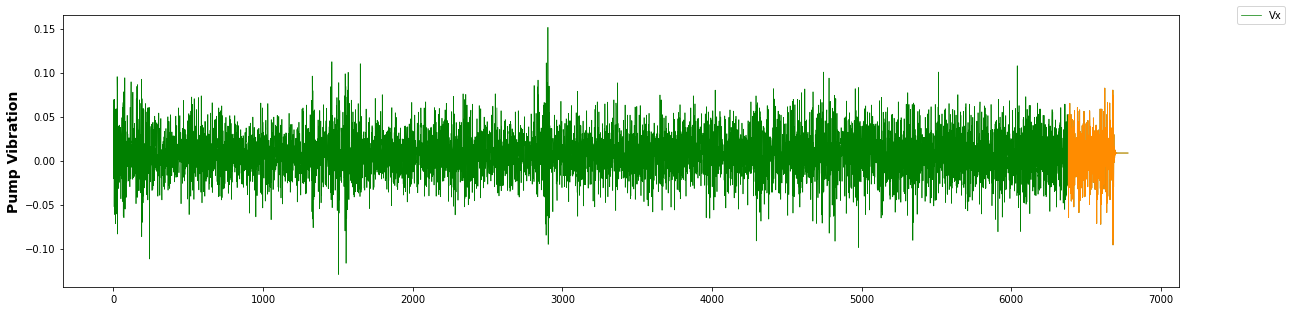

In [20]:
dftail = df2.tail(400)
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.plot(df2.index, df2['value'],linewidth=0.7,color='green',label=Temperature)
ax.plot(dftail.index, dftail['value'],linewidth=0.9,color='darkorange')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('Pump Vibration',fontsize=14,weight="bold")